### Deep Mutational Screen of Illumina Amplicon Sequencing Data - example notebook 

We start the analysis from (one or more) **Illumina** amplicon sequencing data sets, i.e. **fastq files** for the foward (R1) and respective reverse (R2) reads. 
Please run the `Illumina_preprocess_and_align_reads.py` file, which includes (1.) **demultiplexing** and **read quality filtering**, and (2.) **aligning** the reads to the reference using blastn. Please refer to the `README.md` file for details.

All the analysis below is also combined and automated in the `analyze_mutation_enrichment.py` file. 

#### The notebook includes the following steps: 
Overall, we analyze the aligned reads, including calculation and visualization of: 
- insertions, deletions within the sequence (note that these may be sequencing errors or real biological effects)
- mutation enrichment within the sequence
- mutation rates
- mutagenic spectrum 


In [98]:
## import packages, the used versions are specified in the requirements.txt file
import os
from Bio.SeqIO import QualityIO
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
from utils import dna_rev_comp, translate_dna2aa
import pandas as pd
import seaborn as sns
import pickle as pkl
import matplotlib.colors as mcolors
from scipy import stats
import os.path
from matplotlib.lines import Line2D
import json
import matplotlib.gridspec as gridspec
from preprocessing_functions import *
from plotting import *
from characterization_from_blast_alignments import *
from importlib import reload
import json
from Bio import SeqIO
# Define the colors
from matplotlib.colors import LinearSegmentedColormap


In [12]:
###### in principle, to analyze contamination with the WT

# Folder = "P04_RL1_linkers"
# Bc = "BC1"
# read_dirs = ["R1", "R2"]
# variant = "RL1"
# Section = "S1"
# all_alignments = {}
# data_type = "AA"
# read_dir = "R2"
# homedir =  "data/fastq/also_map_to_WTAraC"


# with open(f"{homedir}/config.json") as f:
#   config = json.load(f)

  
# with open(f"{homedir}/{Folder}/blast/alignments/{variant}_{Bc}_{Section}_Nt_filt_{read_dir}.out", "r") as file:
#         blast_output = json.load(file)

# mapped_to = {}
# for i in range(len(blast_output["BlastOutput2"])):
#     ref_name = blast_output["BlastOutput2"][i]["report"]["results"]["search"]["query_title"]
#     #print("######", ref_name)

#     for read in blast_output["BlastOutput2"][i]["report"]["results"]["search"]["hits"]:
#         read_len = len(read["hsps"][0]["qseq"])
#         if read_len > 25: ## read len until LOV2 = 27 (R1), 30 (R2)
#             #print(read["hsps"][0]["qseq"])
#             mapped_to[ref_name + "_nref"] = mapped_to.get(ref_name + "_nref", 0) + 1
#         else: 
#             mapped_to[ref_name] = mapped_to.get(ref_name, [])
#             mapped_to[ref_name].append(read["description"][0]["title"])
    
#     n_reads_mapped = len(blast_output["BlastOutput2"][i]["report"]["results"]["search"]["hits"])
#     print(n_reads_mapped, "aligned to", ref_name)
# print("after len filtering:", "WT:", mapped_to["WT AraC (no LOV2 inserted)_nref"], ", AraCLOV2:", mapped_to["RL1_S1_ref RL1 S1 DNA sequence_nref"])
# print("fraction of WT", mapped_to["WT AraC (no LOV2 inserted)_nref"]/(mapped_to["RL1_S1_ref RL1 S1 DNA sequence_nref"]+mapped_to["WT AraC (no LOV2 inserted)_nref"]))

43092 aligned to WT AraC (no LOV2 inserted)
42984 aligned to RL1_S1_ref RL1 S1 DNA sequence
after len filtering: WT: 36749 , AraCLOV2: 37046
fraction of WT 0.49798766854122906


### Read and restructure the blast alignment data

In [83]:
###### specify the parameters for the analysis ######


homedir =  "data/fastq/P02_RL8_LOV2" ## folder where the fastq files are stored

Bc = "BC1" ## barcode that should be analyzed
read_dirs = ["R1", "R2"] ## which reads should be analyzed
Section = "S1" ## which section should be analyzed
all_alignments = {}
data_type = "AA" ## which data_type should be analyzed, either "AA" or "Nt"

LOV_startseq = "ttagccacaa".upper() ## region of interest
LOV_endseq = "cggccaaa".upper()

with open(f"{homedir}/config.json") as f:
  config = json.load(f)

variant = config["variant"]

FigFolder = f"{os.getcwd()}/final_output/{variant}_w_nb/"
if not os.path.exists(FigFolder):
    os.makedirs(FigFolder)

  

In [84]:
###### read the blast alignments ######

all_alignments = {}
all_coverages = {}
data_type = "AA"

for read_dir in read_dirs:

    # Open the blast oujtplut JSON file and load it as a dictionary
    print("################",  read_dir,   "################")
    with open(f"{homedir}/blast/alignments/{variant}_{Bc}_{Section}_Nt_filt_{read_dir}.out", "r") as file:
        blast_output = json.load(file)

    ## reference
    amplicon_seq = str(SeqIO.read(f"{homedir}/references/{variant}_{Bc}_{Section}_Nt_filt_ref.fasta", "fasta").seq)

    amplicon_AA = translate_dna2aa(amplicon_seq)

    blast_alignments = blast_output["BlastOutput2"][0]["report"]["results"]["search"]["hits"].copy()

    LOV2_startidx = amplicon_seq.index(LOV_startseq)
    LOV2_endidx = amplicon_seq.index(LOV_endseq) + len(LOV_endseq)

    ### filter blast alignments for regions that include LOV2 start site (include 10 nucleotides before and after the LOV2 start site)
    print(len(blast_alignments), "alignments before filtering for LOV2 insertion site")

    filter_for_region = LOV2_startidx if read_dir=="R1" else LOV2_endidx 

    blast_alignments = [alignment for alignment in blast_alignments if alignment["hsps"][0]["query_from"] <= filter_for_region-10 and alignment["hsps"][0]["query_to"] >= filter_for_region+10]
    print(len(blast_alignments), "alignments after filtering for LOV2 insertion site")

    ## restructure the blast alignments to store only the (for us) relevant sequence information
    alignments, coverages = restructure_alignments(blast_alignments, query_seq=amplicon_seq, read_dir=read_dir)

    all_alignments[read_dir] = alignments
    all_coverages[read_dir] = coverages



################ R1 ################
39192 alignments before filtering for LOV2 insertion site
27038 alignments after filtering for LOV2 insertion site
80 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence 
################ R2 ################
37017 alignments before filtering for LOV2 insertion site
23581 alignments after filtering for LOV2 insertion site
61 sequences are excluded, since they do not cover the start (R1) or end (R2) of the amplicon sequence 


### Analyze the blast alignments 

In [85]:
#### characterize the enrichments ######

all_enrichments = {"R1":{}, "R2":{}}

for read_dir in read_dirs: 

    all_variants, indels,  enrichment_counts, enrichment_relative = characterize_DMS_blast_alignment(all_alignments[read_dir], amplicon_seq, data_type=data_type,read_dir=read_dir, exclude_not_covered_regions=False)

    all_enrichments[read_dir]["all_variants"] = pd.DataFrame.from_dict(all_variants)
    all_enrichments[read_dir]["indels"] = indels
    all_enrichments[read_dir]["enrichment_counts"] = enrichment_counts
    all_enrichments[read_dir]["enrichment_relative"] = enrichment_relative

### combine enrichments of R1 and R2
reference = amplicon_AA if data_type == "AA" else amplicon_seq

total_variants = all_enrichments[read_dirs[0]]["all_variants"] + all_enrichments[read_dirs[1]]["all_variants"]

total_enrichment = all_enrichments[read_dirs[0]]["enrichment_counts"] + all_enrichments[read_dirs[1]]["enrichment_counts"]

total_relative_enrichment = total_enrichment/total_variants.sum()

### combine indels of R1 and R2
total_indels = all_enrichments[read_dirs[0]]["indels"] + all_enrichments[read_dirs[1]]["indels"]

total_indels_freq = total_indels/(all_coverages[read_dirs[0]]+all_coverages[read_dirs[1]]) # here, we use the coverage calculated before indel reads were filtered out

## we set regions with low coverage (everything below 2000) to nan
enrichment_coverages = total_variants.sum()
total_relative_enrichment.loc[:,enrichment_coverages < 2000] = np.nan

675 sequences with off target indels are excluded
26283 sequences are included in the enrichment analysis
943 sequences with off target indels are excluded
22577 sequences are included in the enrichment analysis


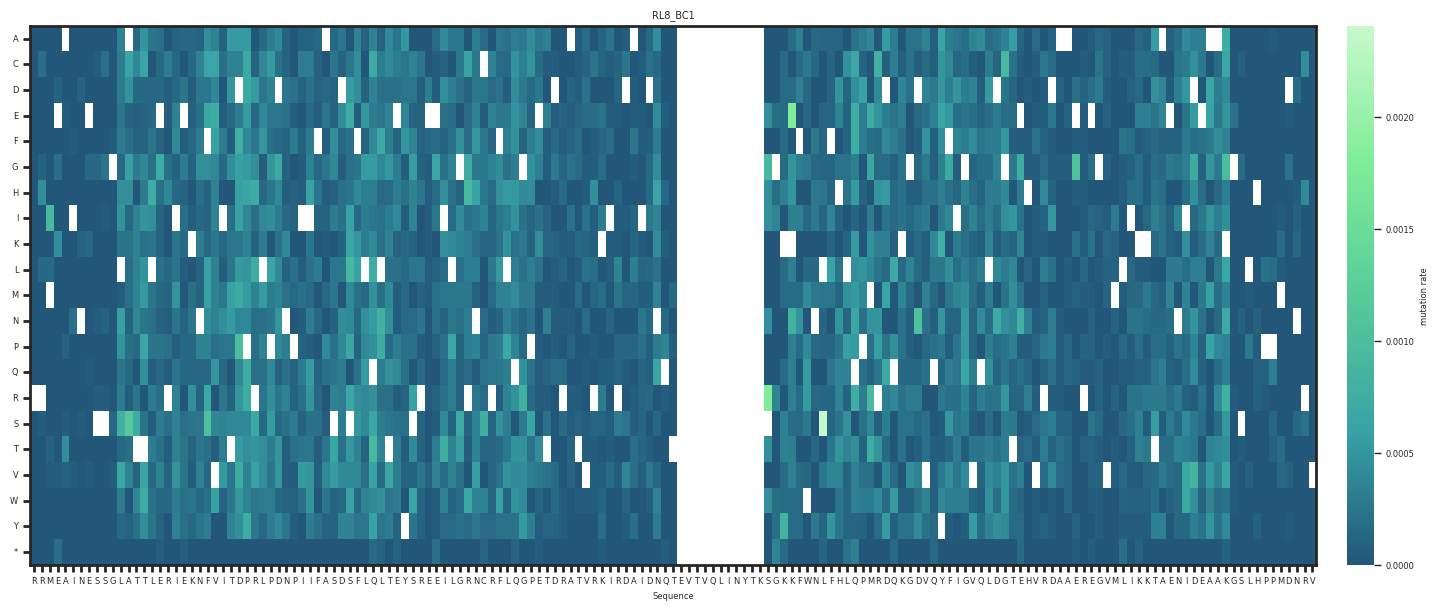

In [105]:
# Define the colormap
colors = ["#22577A", "#C7F9CC"]  # Light green to deep blue
cmap = LinearSegmentedColormap.from_list("custom_cmap", colors, N=256)


## reload the evaluation functions
from importlib import reload 
import plotting
reload(plotting)
from plotting import *
import functions_
reload(functions_)
from functions_ import *

colors = [
    (0.0, "#000000"),  # Black (small fraction)
    (0.1, "#3b528b"),  # Blue (starts earlier)
    (0.4, "#21918c"),  # Greenish blue
    (0.7, "#5ec962"),  # Green
    (1.0, "#fde725")   # Yellow (final)
]

colors = [
    "#080C26",  # Black (small fraction)
     "#3b528b",  # Blue (starts earlier)
    "#21918c",  # Greenish blue
     "#5ec962",  # Green
    "#fde725"  # Yellow (final)
]

colors = [
    #"#2C3E5E",  
    "#22577A",  # Deep blue
    "#38A3A5",  # Teal
    "#57CC99",  # Medium green
    "#80ED99",  # Bright green
    "#C7F9CC"   # Light pastel green
]

# Create the colormap
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom_green_blue", colors, N=256)



# Create the custom colormap
# custom_cmap = mcolors.LinearSegmentedColormap.from_list("black_to_blue_to_yellow", colors)



plot_mutation_enrichment(total_relative_enrichment, ref_seq=reference, samplename=f"{variant}_{Bc}", data_type="AA", FigFolder=FigFolder, vmax=None, cmap = custom_cmap)

In [6]:
### if you want, you can now also filter for the region of interest: 
roi_startidx = LOV2_startidx if data_type == "DNA" else LOV2_startidx//3
roi_endidx = LOV2_endidx if data_type == "DNA" else LOV2_endidx//3

total_relative_enrichment_roi = total_relative_enrichment.iloc[:,roi_startidx:roi_endidx]

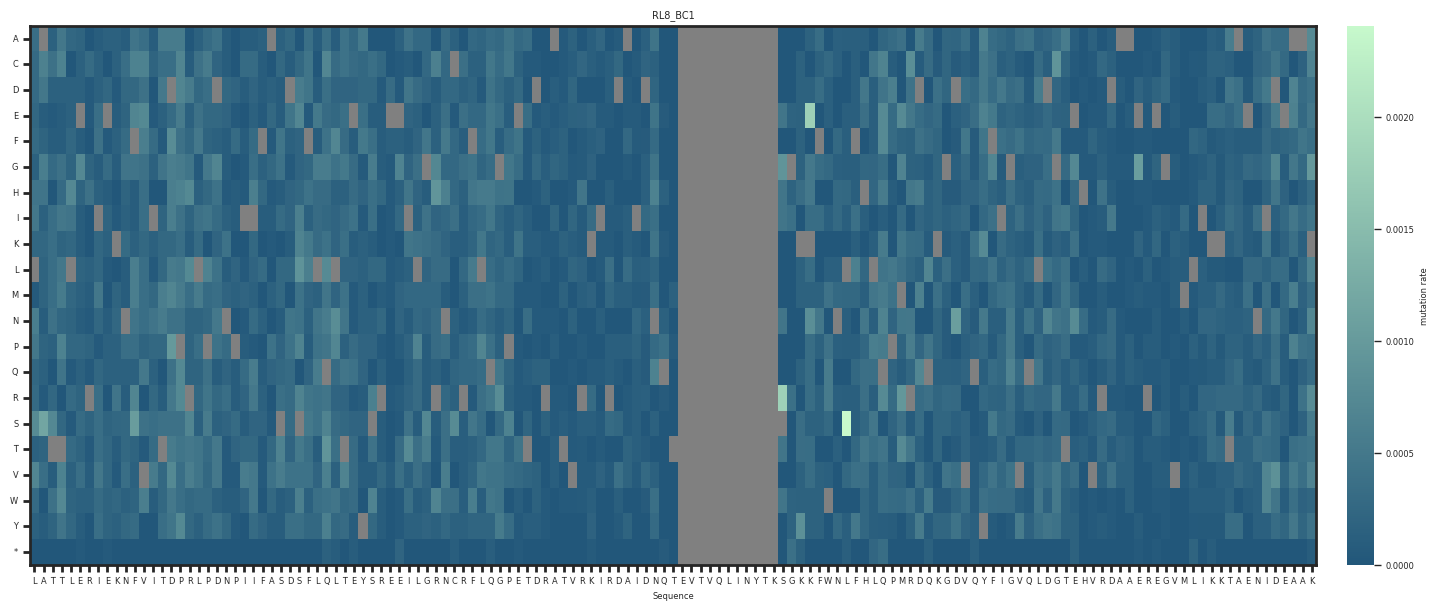

In [7]:
plot_mutation_enrichment(total_relative_enrichment_roi, ref_seq=reference[roi_startidx:roi_endidx], samplename=f"{variant}_{Bc}", data_type="AA", FigFolder=FigFolder, vmax=None, cmap = cmap)

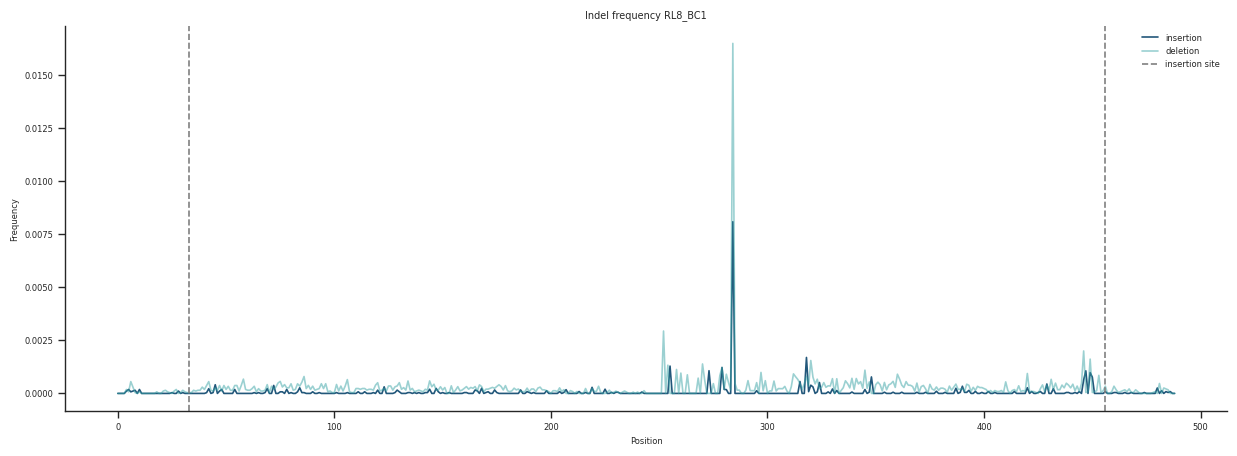

In [13]:
plot_indel_freqs(total_indels_freq,  filename=f"{variant}_{Bc}", FigFolder=FigFolder, roi_start_idx=LOV2_startidx, roi_end_idx=LOV2_endidx, color1="#22577A", color2="#38A3A5")
plt.show()

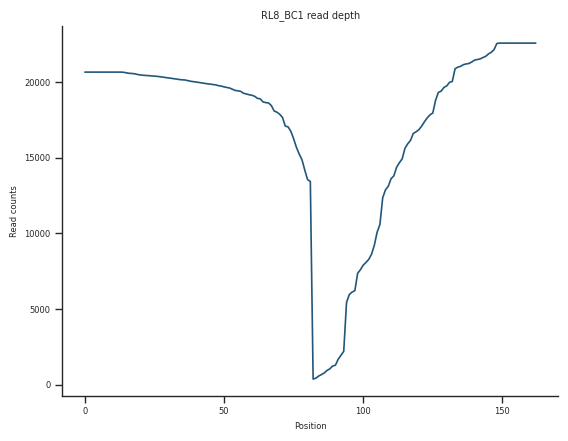

In [15]:
## we can also plot the coverage
coverage_plot(total_variants.sum(), FigFolder=FigFolder, samplename = f"{variant}_{Bc}", color = "#22577A")

In [65]:


DP6_indels = pd.read_csv("/home/student/anna/DMS_analysis/final_output/DP6/combined/enrichments/DNA/DP6_BC1_S1_combined_roiFalse_DNA_indel_freq.csv", index_col=0)
RL8_indels = pd.read_csv("/home/student/anna/DMS_analysis/final_output/RL8/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_indel_freq.csv", index_col=0)  
RL8_mutations = pd.read_csv("/home/student/anna/DMS_analysis/final_output/RL8/combined/enrichments/AA/RL8_BC1_S1_combined_roiTrue_AA_enrichment_relative.csv", index_col=0)
DP6_mutations = pd.read_csv("/home/student/anna/DMS_analysis/final_output/DP6/combined/enrichments/AA/DP6_BC1_S1_combined_roiTrue_AA_enrichment_relative.csv", index_col=0)

DP6_indels.dropna(axis=1, how="any", inplace=True)
RL8_indels.dropna(axis=1, how="any", inplace=True)

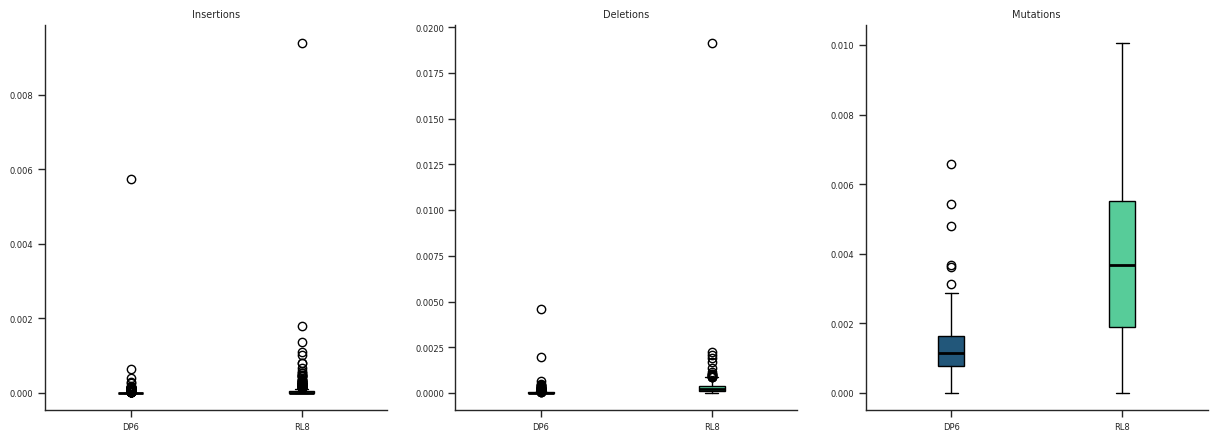

In [74]:
DP6_insertions = DP6_indels.loc["insertion",:]
RL8_insertions = RL8_indels.loc["insertion",:]
DP6_deletions = DP6_indels.loc["deletion",:]
RL8_deletions = RL8_indels.loc["deletion",:]
DP6_muts = DP6_mutations.sum()
RL8_muts = RL8_mutations.sum()

# Define colors
color_DP6 = "#22577A"  # Replace with actual color (e.g., "#1f77b4")
color_RL8 = "#57CC99"  # Replace with actual color (e.g., "#ff7f0e")
median_color = "black"  # Replace with actual color (e.g., "black")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Insertions
bp1 = axes[0].boxplot([DP6_insertions, RL8_insertions], tick_labels=["DP6", "RL8"], 
                       showfliers=True, patch_artist=True)
axes[0].set_title("Insertions")

# Deletions
bp2 = axes[1].boxplot([DP6_deletions, RL8_deletions], tick_labels=["DP6", "RL8"], 
                       showfliers=True, patch_artist=True)
axes[1].set_title("Deletions")

# Mutations
bp3 = axes[2].boxplot([DP6_muts, RL8_muts], tick_labels=["DP6", "RL8"], 
                       showfliers=True, patch_artist=True)
axes[2].set_title("Mutations")

# Set colors for each dataset in each boxplot
for bp in [bp1, bp2, bp3]:
    for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
        box.set(facecolor=color)  # Fill the box with the defined color

    for median in bp['medians']:
        median.set(color=median_color, linewidth=2)  # Set median color

plt.show()




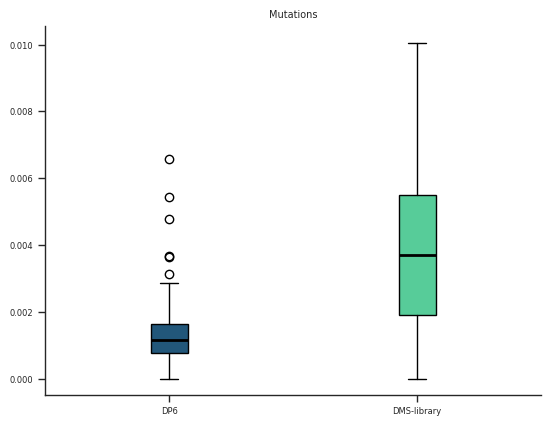

In [75]:
# Mutations
bp = plt.boxplot([DP6_muts, RL8_muts], tick_labels=["DP6", "DMS-library"], 
                       showfliers=True, patch_artist=True)
plt.title("Mutations")

# Set colors for each dataset in each boxplot

for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
    box.set(facecolor=color)  # Fill the box with the defined color

for median in bp['medians']:
    median.set(color=median_color, linewidth=2)  # Set median color

plt.show()

In [78]:
all_DP6_mutations = DP6_mutations.iloc[:-1,:].values.flatten()
all_RL8_mutations = RL8_mutations.iloc[:-1,:].values.flatten()

all_DP6_mutations = all_DP6_mutations[~np.isnan(all_DP6_mutations)]
all_RL8_mutations = all_RL8_mutations[~np.isnan(all_RL8_mutations)]

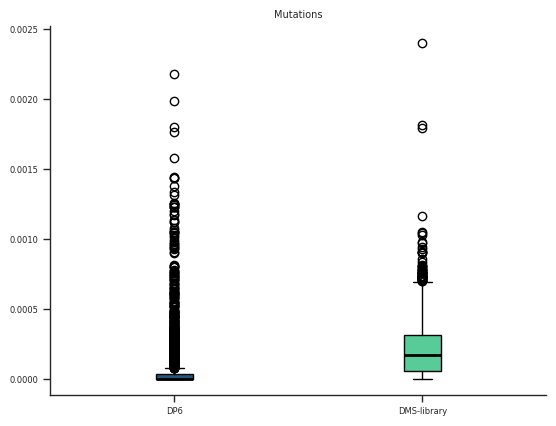

In [79]:
# Mutations
bp = plt.boxplot([all_DP6_mutations, all_RL8_mutations], tick_labels=["DP6", "DMS-library"], 
                       showfliers=True, patch_artist=True)
plt.title("Mutations")

# Set colors for each dataset in each boxplot

for box, color in zip(bp['boxes'], [color_DP6, color_RL8]):
    box.set(facecolor=color)  # Fill the box with the defined color

for median in bp['medians']:
    median.set(color=median_color, linewidth=2)  # Set median color

plt.show()

In [80]:
print(np.median(DP6_muts), "median DP6 mutations per position ")
print(np.median(RL8_muts), "median RL8 mutations per position ")
print(np.median(all_DP6_mutations), "median DP6 mutations per possible change")
print(np.median(all_RL8_mutations), "median RL8 mutations per possible change")

0.0011526479750777452 median DP6 mutations per position 
0.0036900369003680005 median RL8 mutations per position 
0.0 median DP6 mutations per possible change
0.0001690180521563 median RL8 mutations per possible change


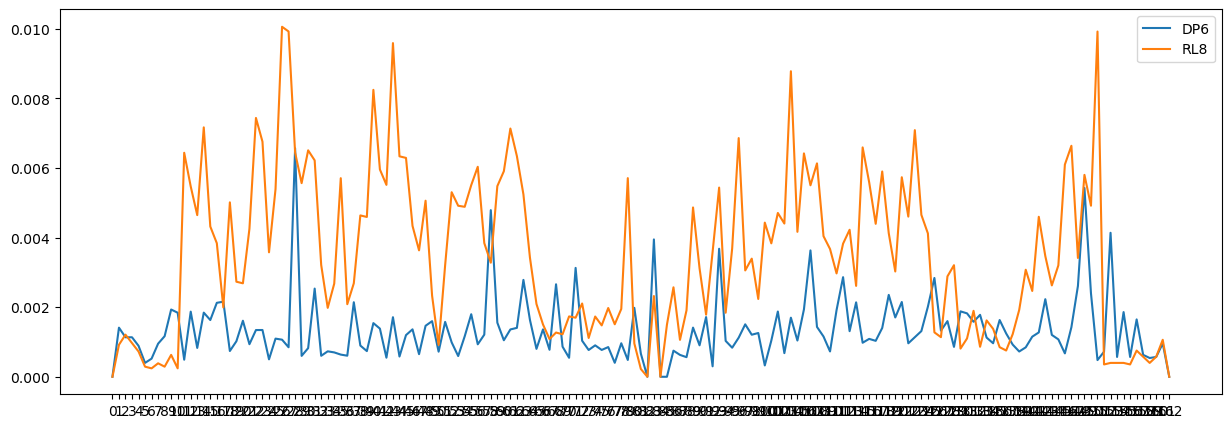

In [61]:
plt.figure(figsize=(15,5))
plt.plot(DP6_muts, label = "DP6")
plt.plot(RL8_muts, label = "RL8")
plt.legend()    
plt.show()

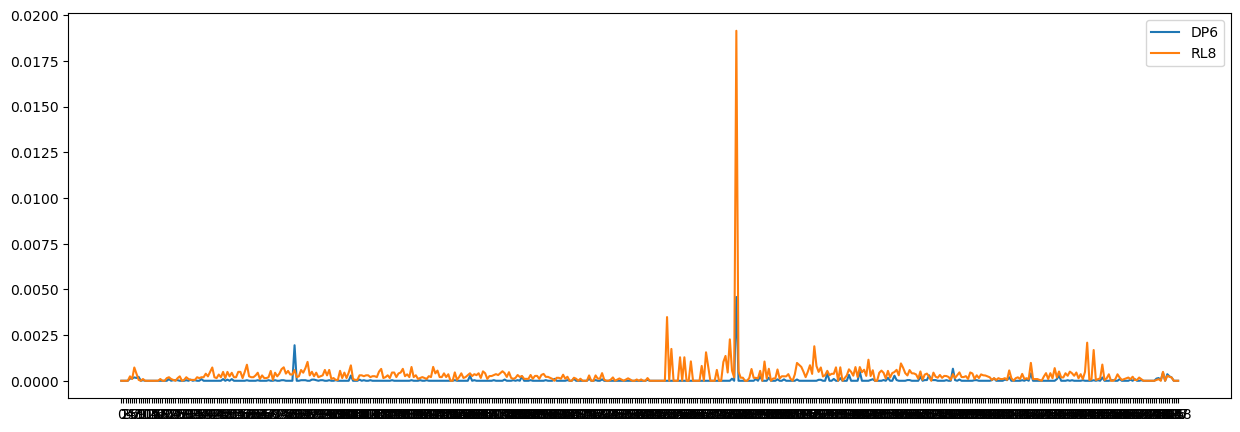

In [57]:
plt.figure(figsize=(15,5))
plt.plot(DP6_deletions, label = "DP6")
plt.plot(RL8_deletions, label = "RL8")
plt.legend()    
plt.show()


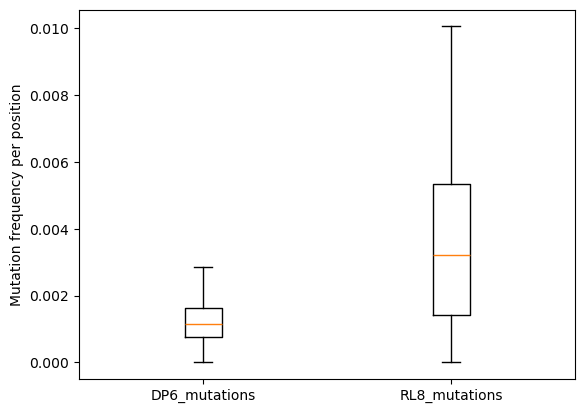

In [16]:
plt.boxplot([DP6_muts, RL8_muts], tick_labels = ["DP6_mutations", "RL8_mutations"], showfliers=False)
plt.ylabel("Mutation frequency per position")
plt.show()

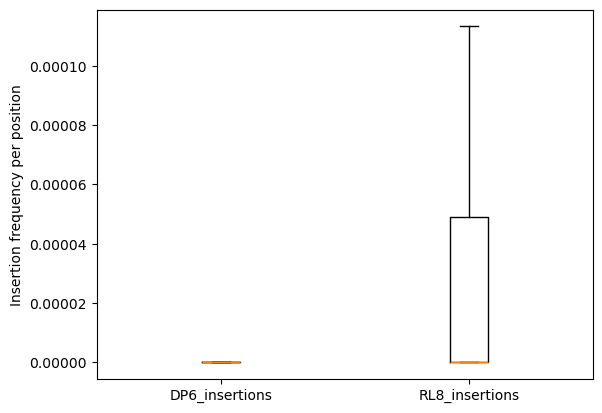

In [17]:
plt.boxplot([DP6_insertions, RL8_insertions], tick_labels = ["DP6_insertions", "RL8_insertions"], showfliers=False)
plt.ylabel("Insertion frequency per position")
plt.show()

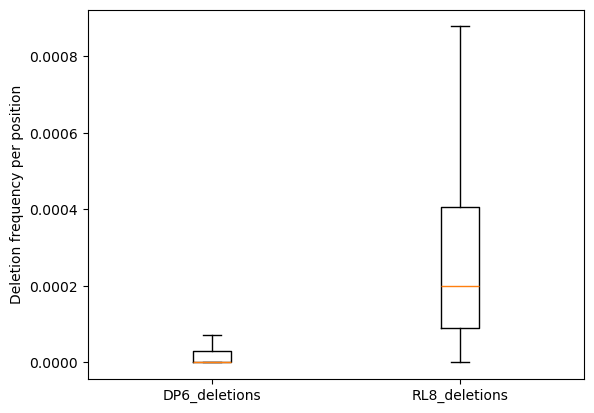

In [39]:
plt.boxplot([ DP6_deletions, RL8_deletions], tick_labels = ["DP6_deletions", "RL8_deletions"], showfliers=False)
plt.ylabel("Deletion frequency per position")
plt.show()

In [124]:
BC1_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R1/enrichments/AA/R36_BC1_S1_R1_AA_linker_distribution.csv", index_col=0).T
BC2_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R1/enrichments/AA/R36_BC2_S1_R1_AA_linker_distribution.csv", index_col=0).T
BC3_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R1/enrichments/AA/R36_BC3_S1_R1_AA_linker_distribution.csv", index_col=0).T

all_linkers_vars = list(set(list(BC1_linkers.columns) + list(BC2_linkers.columns)+ list(BC3_linkers.columns)))
all_linker_perc = pd.DataFrame(columns = all_linkers_vars, index = ["BC1", "BC2", "BC3"], data = 0, dtype=np.float64)

for linker in all_linkers_vars: 
    if linker in BC1_linkers.columns:
        all_linker_perc.loc["BC1", linker] = BC1_linkers.loc["percentage", linker]
    if linker in BC2_linkers.columns:
        all_linker_perc.loc["BC2", linker] = BC2_linkers.loc["percentage", linker] 
    if linker in BC3_linkers.columns:
        all_linker_perc.loc["BC3", linker] = BC3_linkers.loc["percentage", linker]


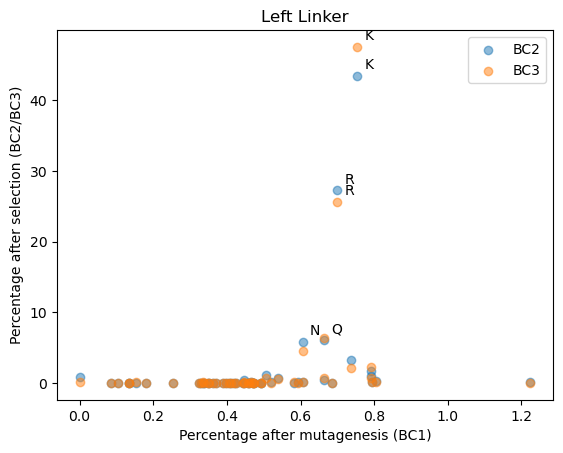

In [128]:
plt.scatter(all_linker_perc.loc["BC1",:], all_linker_perc.loc["BC2",:], label = "BC2", alpha = 0.5)
plt.scatter(all_linker_perc.loc["BC1",:], all_linker_perc.loc["BC3",:], label = "BC3", alpha = 0.5)
plt.xlabel("Percentage after mutagenesis (BC1)")
plt.ylabel("Percentage after selection (BC2/BC3)")

for i, (x, y) in enumerate(zip(all_linker_perc.loc["BC1", :], all_linker_perc.loc["BC2", :])):
    if y > 5:  
        plt.annotate(all_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')
for i, (x, y) in enumerate(zip(all_linker_perc.loc["BC1", :], all_linker_perc.loc["BC3", :])):
    if y > 10:  
        plt.annotate(all_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')
plt.legend(frameon = True)
plt.title("Left Linker")
plt.savefig("/home/student/anna/DMS_analysis/output/R36/blast00/R1/plots/AA/R36_linker_evolution_scatter.pdf", bbox_inches='tight')
plt.show()


In [81]:
BC1_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R2/enrichments/AA/R36_BC1_S1_R2_AA_linker_distribution.csv", index_col=0).T
BC2_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R2/enrichments/AA/R36_BC2_S1_R2_AA_linker_distribution.csv", index_col=0).T
BC3_linkers = pd.read_csv("/home/student/anna/DMS_analysis/output/R36/blast00/R2/enrichments/AA/R36_BC3_S1_R2_AA_linker_distribution.csv", index_col=0).T

all_linkers_vars = list(set(list(BC1_linkers.columns) + list(BC2_linkers.columns) + list(BC3_linkers.columns)))
all_linker_perc = pd.DataFrame(columns = all_linkers_vars, index = ["BC1", "BC2", "BC3"], data = 0, dtype=np.float64)

for linker in all_linkers_vars: 
    if linker in BC1_linkers.columns:
        all_linker_perc.loc["BC1", linker] = BC1_linkers.loc["percentage", linker]
    if linker in BC2_linkers.columns:
        all_linker_perc.loc["BC2", linker] = BC2_linkers.loc["percentage", linker] 
    if linker in BC3_linkers.columns:
        all_linker_perc.loc["BC3", linker] = BC3_linkers.loc["percentage", linker]


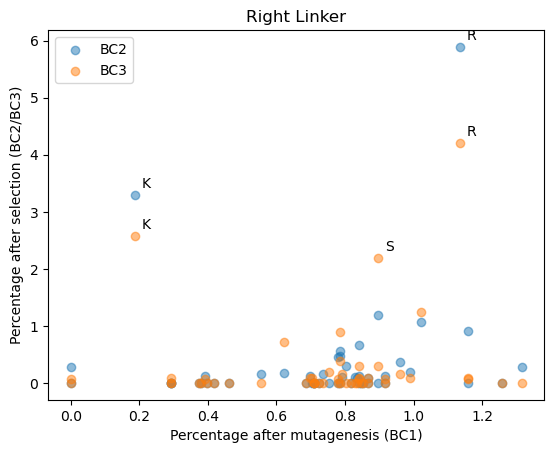

In [134]:
plt.scatter(all_linker_perc.loc["BC1",:], all_linker_perc.loc["BC2",:], alpha=0.5, label = "BC2")
plt.scatter(all_linker_perc.loc["BC1",:], all_linker_perc.loc["BC3",:], alpha=0.5, label = "BC3")
plt.legend(frameon = True)

plt.xlabel("Percentage after mutagenesis (BC1)")
plt.ylabel("Percentage after selection (BC2/BC3)")
plt.title("Right Linker")
for i, (x, y) in enumerate(zip(all_linker_perc.loc["BC1", :], all_linker_perc.loc["BC2", :])):
    if y > 2:  
        plt.annotate(all_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')

for i, (x, y) in enumerate(zip(all_linker_perc.loc["BC1", :], all_linker_perc.loc["BC3", :])):
    if y > 2:  
        plt.annotate(all_linker_perc.columns[i], (x, y), textcoords="offset points", xytext=(5,5), ha='left')
plt.savefig("/home/student/anna/DMS_analysis/output/R36/blast00/R2/plots/AA/R36_linker_evolution_scatter.pdf", bbox_inches='tight')


plt.show()


In [394]:
RL8_mutations = pd.read_csv("/home/student/anna/DMS_analysis/output/final_output/RL8/blast/combined/enrichments/AA/RL8_BC1_S1_combined_roiFalse_AA_enrichment_relative.csv", index_col=0)
RL8_DNA_mutations = pd.read_csv("/home/student/anna/DMS_analysis/output/final_output/RL8/blast/combined/enrichments/DNA/RL8_BC1_S1_combined_roiFalse_DNA_enrichment_relative.csv", index_col=0)
RL8_encoded_muts = pd.read_csv("/home/student/anna/DMS_analysis/output/P0111_RetronLib/BC3_R1/blastpipeline/enrichments/BC3_RL_encoded_mutations.csv", index_col=0).T

In [370]:
RL8_observed_ref = "CGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAAGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTG"
## see /home/student/anna/DMS_analysis/data/fastq/P02_RL8_LOV2/references/RL8_BC1_S1_Nt_filt_ref.fasta

In [371]:
RL8_encoded_ref = "CAGCTGCTGCTGCGCCGCATGGAAGCGATTAACGAAAGCAGCGGTTTAGCCACAACGCTGGAACGCATTGAAAAGAATTTCGTAATCACAGACCCGCGCCTTCCCGACAATCCAATTATTTTTGCGTCCGATAGCTTCCTGCAATTAACCGAATACAGCCGCGAAGAAATTCTGGGTCGTAATTGTCGCTTCCTTCAGGGGCCAGAGACTGACCGTGCTACGGTACGCAAAATCCGCGACGCAATCGACAATCAAACGGAAGTCACGGTTCAGTTGATTAACTATACGAAGAGCGGAAAAAAATTCTGGAATTTATTTCACTTGCAGCCTATGCGTGACCAGAAGGGCGATGTCCAGTATTTCATTGGCGTTCAGCTTGATGGTACCGAGCATGTTCGCGATGCTGCGGAGCGTGAAGGTGTAATGTTAATTAAAAAGACTGCTGAAAACATTGATGAGGCGGCCAAAGGGAGCCTGCATCCGCCGATGGATAACCGCGTGCGCGAAGCGTGC"

In [372]:
cut_left = RL8_encoded_ref.index("CGCCGCATGGAAGCGATTAA")
cut_right = RL8_encoded_ref.index("TGGATAACCGCGTG") + len("TGGATAACCGCGTG")

In [395]:
RL8_encoded_muts = RL8_encoded_muts.iloc[:,cut_left:cut_right]

In [396]:
RL8_encoded_muts_prop = RL8_encoded_muts.iloc[0,:].values
RL8_encoded_muts_prop = RL8_encoded_muts_prop/RL8_encoded_muts_prop.sum()

In [314]:
# RL8_DNA_muts_prop = RL8_DNA_mutations.sum()
# RL8_DNA_muts_prop = RL8_DNA_muts_prop/RL8_DNA_muts_prop.sum()

In [397]:
RL8_DNA_muts_prop = RL8_DNA_mutations.sum()
## mask pos with max 
mask_max = np.where(RL8_DNA_muts_prop == RL8_DNA_muts_prop.max())[0][0]
RL8_DNA_muts_prop[mask_max] = np.nan
RL8_DNA_muts_prop = RL8_DNA_muts_prop/RL8_DNA_muts_prop.sum()



RL8_DNA_mutations_sum = RL8_DNA_mutations.sum()
RL8_DNA_mutations_sum[mask_max] = np.nan

/tmp/ipykernel_3498679/544745654.py:4: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  RL8_DNA_muts_prop[mask_max] = np.nan
/tmp/ipykernel_3498679/544745654.py:10: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  RL8_DNA_mutations_sum[mask_max] = np.nan


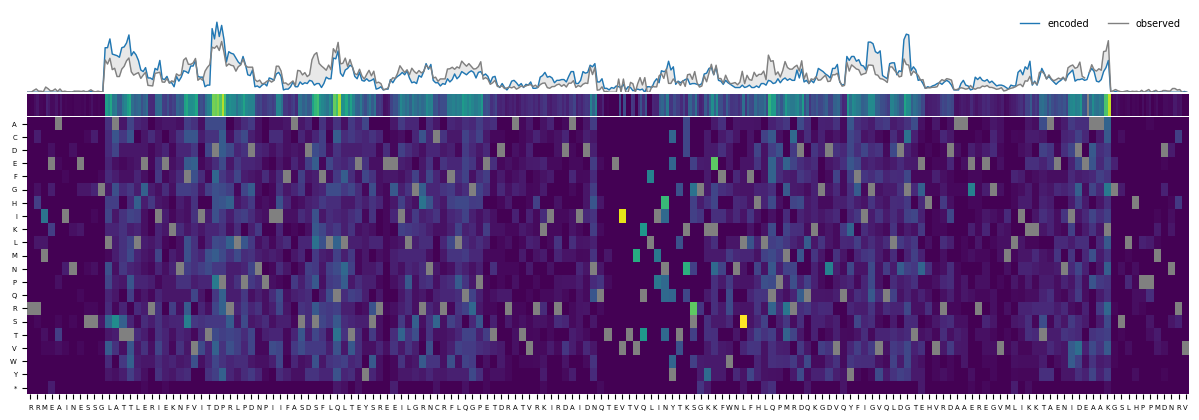

In [398]:
fig, axes = plt.subplots(3,1, figsize=(15, 5), height_ratios=[0.3, 0.08, 1])
## put plots closer together
plt.subplots_adjust(hspace=0.01)
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].spines['left'].set_visible(False)

axes[0].plot(RL8_encoded_muts_prop, label = "encoded", linewidth = 1)
axes[0].plot(RL8_DNA_muts_prop, label = "observed", linewidth = 1, color = "grey")
axes[0].set_xlim(0, len(RL8_encoded_muts.columns))
axes[0].set_ylim(0,0.012)
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].legend(frameon = False, ncol=2, fontsize = 7)
axes[0].fill_between(range(len(RL8_encoded_muts_prop)), RL8_encoded_muts_prop, RL8_DNA_muts_prop, color="lightgray", alpha=0.5)

sns.heatmap(pd.DataFrame(RL8_DNA_mutations_sum).T, cmap= "viridis", cbar = False, ax = axes[1], xticklabels=False, yticklabels=False, vmax = 0.01)
axes[1].set_facecolor('gray')



sns.heatmap(RL8_mutations, cmap= "viridis", cbar = False, ax = axes[2],yticklabels=True,xticklabels=translate_dna2aa(RL8_observed_ref))
axes[2].set_yticklabels(axes[2].get_yticklabels(), rotation=1, fontsize = 5)
axes[2].set_xticklabels(axes[2].get_xticklabels(), rotation=1, fontsize = 5)
axes[2].set_facecolor('gray')
plt.savefig("/home/student/anna/DMS_analysis/output/final_output/RL8/RL8_encoded_vs_observed.pdf", bbox_inches='tight')
plt.savefig("/home/student/anna/DMS_analysis/output/final_output/RL8/RL8_encoded_vs_observed.png", bbox_inches='tight')

plt.show()